In [3]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import seaborn as sns

## Dependencies
I ran this all on my laptop no problems.
There shouldnt be anything too dependent on version numbers but I was running:
- Python 3.7.1 
- Torch 1.5.0

## Contents
- Loading input data and creating dataset and dataloaders
- Creating a model
- Defining the loss function 
- Define the training regime
- Predicting Results
- Effect of changing hyperparameters

There is quite a lot of documentation on the pytorch webiste: https://pytorch.org/docs/stable/index.html and I'll try and show you where to look for the different components for network training.

First were going to see what devices (CPU or CUDA) we have available

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda Available')
else:
    print('CPU only')

CPU only


We are now going to make a class of hyperparameters. These are values we might choose to change to control the training of the network.

In [5]:
class Args:
    def __init__(self):
        self.batch_size = 4
        self.log_interval = 10
        self.learning_rate = 1e-2
        self.epochs = 25
        self.train_val_prop = 0.9
        self.epochs = 2
args = Args()

As a simple example we are going to try segmenting the hippocampus from some T1 data. They have already been cropped quite tightly to the hippocampus to let us do it quickly. Therefore the data is a numpy array but you can also do this with path names if thats the form your data is in.

We have one channel data but we have to reshape the data to be explictly one channel. Pytorch by default expects channels first and so the data needs to take the form (num_samples, channels, x_dim, y_dim, z_dim). We also normally scale the X values but this depends a lot on your data and task. Here we are just going to remove the extreme values.

In [6]:
X = np.load('X_training_pruning.npy')
X = np.reshape(X, (-1, 1, 64, 64, 64))
print(X.shape)

X = X / np.percentile(X, 99.9)
X[ X > 1] = 1
X = X - np.mean(X)

(200, 1, 64, 64, 64)


Now load in the labels. For segmentation we probably need this to be one hot - each channel is binary with the class being 1 and the rest of the image being 0. 

This is required by some loss functions and not others, so if you are using an inbuilt function you will want to check what form the function requires to the data to be in. The inbuilt functions can be found here: https://pytorch.org/docs/stable/nn.html#loss-functions

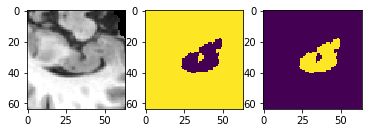

In [7]:
y = np.load('y_training_pruning.npy')
# Convert to one hot
y_store = np.zeros((len(y), 2, 64, 64, 64))
y_store[:,0,:,:,:][y == 0] = 1
y_store[:,1,:,:,:][y == 1] = 1
y = y_store
# Lets have a look at this and make sure its sensible
subj = 0
plt.subplot(1,3,1)
plt.imshow(X[subj, 0, :, :, 30], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y[subj, 0, :, :, 30])
plt.subplot(1,3,3)
plt.imshow(y[subj, 1, :, :, 30])
plt.show()

As you can see the data is a tight crop around the hippocampus - this would not be sensible in most tasks but lets us run this code on laptops. You can now see the one hot labels and hopefully that makes sense. If there were another label we would have another channel with only that label == 1 and that label == 0 on all the other channels.

We now have to make a dataset. The purpose of the datasetis to output the (X,y) batches for training and to do any processing on the data that is required.

For this there is a default class which you can use if you are using paths as the inputs but often for us it is more computationally convinent to preprocess the data a single time. I'm here going to use a custom dataset which takes numpy arrays as the input. 

If we wanted to apply augmentation to the data, this is applied using the dataset function, by applying transforms to the data. 

In [8]:
from torch.utils.data import Dataset
class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        self.transform = transform # This is where you can add augmentations

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

So we now split our data into train and validation and then make the datasets. In this notebook we are going to follow the train/validation/test paradigm, making the validation data as subset of the train data and maintaining the test data out of the loop. 

In [9]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)  # Same seed everytime
proportion = int(args.train_val_prop * len(X)) # Train val split 
X_train = X[:proportion]
X_val = X[proportion:]
y_train = y[:proportion]
y_val = y[proportion:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)

(180, 1, 64, 64, 64) (180, 2, 64, 64, 64)
(20, 1, 64, 64, 64) (20, 2, 64, 64, 64)


These are then passed to dataloaders, which is where we define the batchsize
https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [10]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0, drop_last=True)

Now our data is ready to go, we need to define our model. Im going to make a basic unet. There are a couple of ways of defining the model, which is easiest probably depends on what you want to do with the model - for instance some ways make it easier to access the intermediate filters.

I define the block that is repeated as a static method to create the archicture. 

We basically have three parts:
1. The __init__ -  where we define the components of the model
2. The forward pass - where we define how information propagates through the model
3. (The backwards pass - we dont normally have to define this ourself. It is automatically calculated by the pytorch autograd function. There are a few occassions when you might want to change the backwards pass though. https://pytorch.org/docs/stable/autograd.html) 

Another simple way to define a model is using nn.sequential. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html. There are lots of good examples online for defining the model architectures. 

The UNet architecture we are defining has three inputs: 
1. The in_channels - for this data it is one because we only have the T1. If you were using multimodal input data this would vary
2. The out_channels - this is the number of labels we have, in our case 2 (background and hippocampus)
3. The number of features at each level. This has been set very low so we can train on our laptops. The more features the more parameters.

The model inherits from the nn.Module class.

In [11]:
from collections import OrderedDict
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, init_features=2):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose3d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose3d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose3d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose3d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.seg = nn.Conv3d( in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        seg = self.seg(dec1)
        return torch.sigmoid(seg)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=True,
                        ),
                    ),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "norm1", nn.BatchNorm3d(num_features=features)),

                    (
                        name + "conv2",
                        nn.Conv3d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=True,
                        ),
                    ),
                    (name + "relu2", nn.ReLU(inplace=True)),
                    (name + "norm2", nn.BatchNorm3d(num_features=features)),
                ]
            )
        )

Having defined our model we can then initialsise an instance of the class.
If we have cuda available, here we have to move the model to the cuda device

In [12]:
model = UNet(in_channels=1, out_channels=2, init_features=2)
if cuda:
    model.cuda()

Its now time to define our loss and optimizer. There are plenty of inbuilt ones but this is how you make your own. It again has to inherit from nn.Module, and we have to define the forward pass for the information propagation. Note that we take the mean over the batch in the loss function.

In [13]:
class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
        self.eps=1e-7

    def forward(self, x, target):
        num_classes = target.shape[1]   # Channels first
        target = target.type(x.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        intersection = torch.sum(x * target, dims)
        cardinality = torch.sum(x + target, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return (1 - dice_loss)

The loss function also would need to be moved to the cuda device. 

The optimizer controls the training process. We have to tell it which parameters to update and the learning rate of the model

In [14]:
import torch.optim as optim
criterion = dice_loss()
if cuda:
    criterion.cuda()
optimizer = optim.Adam(list(model.parameters()), lr=args.learning_rate)


We now have the basic bits we need and can define the for loop for training and train! Yay!

There are lots of extra things that can be added to the for loop but here we will just do the most basic version.

I saved some weights you can just load in so you dont need to train this to completion but you can play with changing values and see what happens. The weights arent well tuned but will give us some segmentations.

Training the model takes about a minute an epoch on my laptop. Probably a good time to go get a cup of tea :) 

In [15]:
from torch.autograd import Variable

args.epochs = 20
loss_store = []
for epoch in range(1, args.epochs+1):
    print('Epoch ', epoch, '/', args.epochs, flush=True)
    
    # First train 
    total_loss = 0
    val_total_loss = 0
    model.train()      #Put the model in training mode
    batches = 0
    for batch_idx, (data, label) in enumerate(train_dataloader):
        if cuda:
            data = data.cuda()
            label = label.cuda()
        data = Variable(data)
        label = Variable(label)    # This calls autograd on our data
        
        batches += 1
        # Forward
        optimizer.zero_grad()
        seg_pred = model.forward(data)
        # Calc loss
        train_loss = criterion(seg_pred, label)
        # Backprop the loss
        train_loss.backward()
        optimizer.step()
        total_loss += train_loss

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data), len(train_dataloader.dataset),
                       100. * (batch_idx+1) / len(train_dataloader), train_loss.item()), flush=True)

    av_loss = (total_loss / batches).detach().cpu().numpy()   # If you dont detach it keeps the whole model
    print('Training set: Average loss: ',  av_loss, flush=True) 
    
    # Now val
    model.eval()
    batches = 0 
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_dataloader):
            if cuda:
                data = data.cuda()
                label = label.cuda()
            data = Variable(data)
            label = Variable(label)
            batches += 1
            pred_seg = model.forward(data)
            loss = criterion(pred_seg, label)
            val_total_loss += loss
    val_av_loss = (val_total_loss / batches).detach().cpu().numpy()
    print('Validation set: Average loss: ',  val_av_loss, flush=True)

    loss_store.append([av_loss, val_av_loss])   # Save the losses so we can plot them
    torch.cuda.empty_cache()  # Clear memory cache
        

Epoch  1 / 20
Train Epoch: 1 [4/180 (2%)]	Loss: 0.722806
Train Epoch: 1 [44/180 (24%)]	Loss: 0.695176
Train Epoch: 1 [84/180 (47%)]	Loss: 0.660565
Train Epoch: 1 [124/180 (69%)]	Loss: 0.614602
Train Epoch: 1 [164/180 (91%)]	Loss: 0.580032
Training set: Average loss:  0.6452269
Validation set: Average loss:  0.74908894
Epoch  2 / 20
Train Epoch: 2 [4/180 (2%)]	Loss: 0.543348
Train Epoch: 2 [44/180 (24%)]	Loss: 0.512750
Train Epoch: 2 [84/180 (47%)]	Loss: 0.462805
Train Epoch: 2 [124/180 (69%)]	Loss: 0.429927
Train Epoch: 2 [164/180 (91%)]	Loss: 0.388705
Training set: Average loss:  0.46099433
Validation set: Average loss:  0.37017226
Epoch  3 / 20
Train Epoch: 3 [4/180 (2%)]	Loss: 0.336863
Train Epoch: 3 [44/180 (24%)]	Loss: 0.278145
Train Epoch: 3 [84/180 (47%)]	Loss: 0.257333
Train Epoch: 3 [124/180 (69%)]	Loss: 0.290709
Train Epoch: 3 [164/180 (91%)]	Loss: 0.263566
Training set: Average loss:  0.3044301
Validation set: Average loss:  0.26199096
Epoch  4 / 20
Train Epoch: 4 [4/180 (2%

(2, 20)


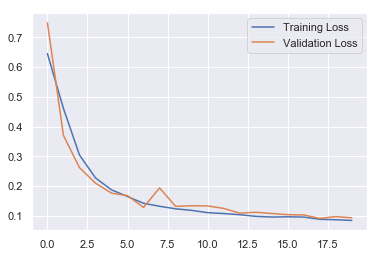

In [16]:
sns.set()
loss_store = np.array(loss_store).T
print(loss_store.shape)
plt.plot(loss_store[0,:])
plt.plot(loss_store[1,:])
plt.legend(['Training Loss', 'Validation Loss'])

We now want to be able to save our model. Most of the time you just want to save weights but you can also save the epoch, optimizer etc so you can restart training from exactly where you were. 

In [17]:
# Save the model, here just the weights
torch.save(model.state_dict(), 'weights')

#torch.save(unet, SAVE_PATH)  This would save all the information so you 
# can load it from exactly where the model was 

Now we want to see if our model did a good job. For this we need the test data which we load just like we did the training data. 

Predicting is then completed by putting the model into evaluation mode and just completing the forwards pass on the data

In [18]:
from torch.autograd import Variable
X = np.load('X_testing_pruning.npy')
X = np.reshape(X, (-1, 1, 64, 64, 64))
print(X.shape)
X = X / np.percentile(X, 99.9)
X[ X > 1] = 1
X_test = X - np.mean(X)
y = np.load('y_testing_pruning.npy')
# Convert to one hot
y_store = np.zeros((len(y), 2, 64, 64, 64))
y_store[:,0,:,:,:][y == 0] = 1
y_store[:,1,:,:,:][y == 1] = 1
y_test = y_store

test_dataset = numpy_dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0, drop_last=True)

LOAD_PATH = 'weights'
test_model = UNet(in_channels=1, out_channels=2, init_features=2)
model_dict = test_model.state_dict()
pretrained_dict = torch.load(LOAD_PATH)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print('weights loaded model = ', len(pretrained_dict), '/', len(model_dict))
test_model.load_state_dict(torch.load(LOAD_PATH))
    
results = []
test_model.eval()
with torch.no_grad():
    for (data, label) in test_dataloader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data = Variable(data)
        label = Variable(label)
        preds = test_model.forward(data)
        results.append(preds.detach().cpu().numpy())


(70, 1, 64, 64, 64)
weights loaded model =  136 / 136


(68, 2, 64, 64, 64)


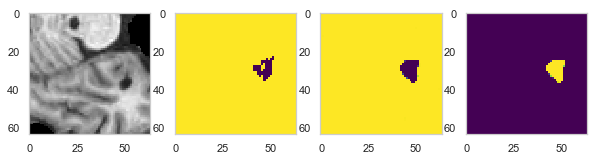

In [25]:
results = np.array(results).squeeze().reshape(-1,2,64,64,64)
print(results.shape)
subj = 60
slices = 10
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,5))
plt.subplot(1,4,1)
plt.imshow(X_test[subj,0,:,:,slices], cmap='gray')
plt.subplot(1,4,2)
plt.imshow(y_test[subj,0,:,:,slices], cmap='viridis')
plt.subplot(1,4,3)
plt.imshow(results[subj,0,:,:,slices], cmap='viridis')
plt.subplot(1,4,4)
plt.imshow(results[subj,1,:,:,slices], cmap='viridis')

We now have a working model architecture which we have successfully trained and created model predictions from. The last thing we are going to explore here is what happens when we change different values.

First lets try varying the learning rate - we are going to do this on just a little bit of the data so it doesnt take long but you can obviously change this. 

Depending on how much computational power you have changing the batch size or the number of features would be interesting

In [19]:
X_loop = X_train
y_loop = y_train
loop_data = numpy_dataset(X_loop, y_loop)
loop_dataloader = DataLoader(loop_data, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)

lr = [1e-4, 1e-2, 1]
for l in lr:
    print('Learning Rate = ', l)
    model = UNet(in_channels=1, out_channels=2, init_features=2)
    optimizer = optim.Adam(list(model.parameters()), lr=l)
    args.epochs = 10
    loss_store = []
    for epoch in range(1, args.epochs+1):
        print('Epoch ', epoch, '/', args.epochs, flush=True)

        # First train 
        total_loss = 0
        val_total_loss = 0
        model.train()      #Put the model in training mode
        batches = 0
        for batch_idx, (data, label) in enumerate(loop_dataloader):
            if cuda:
                data = data.cuda()
                label = label.cuda()
            data = Variable(data)
            label = Variable(label)    # This calls autograd on our data

            batches += 1
            # Forward
            optimizer.zero_grad()
            seg_pred = model.forward(data)
            # Calc loss
            train_loss = criterion(seg_pred, label)
            # Backprop the loss
            train_loss.backward()
            optimizer.step()
            total_loss += train_loss

            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(loop_dataloader.dataset),
                           100. * (batch_idx+1) / len(loop_dataloader), train_loss.item()), flush=True)

        av_loss = (total_loss / batches).detach().cpu().numpy()   # If you dont detach it keeps the whole model
        print('Training set: Average loss: ',  av_loss, flush=True) 

        loss_store.append([av_loss])   # Save the losses so we can plot them
        torch.cuda.empty_cache()  # Clear memory cache
    
    sns.set()
    loss_store = np.array(loss_store).T
    print(loss_store.shape)
    plt.plot(loss_store[0,:])

plt.title('Training Loss with Learning Rate')
plt.legend(['1e-5', '1e-3', '1e-1'], title='Learning Rate')
plt.show()



Learning Rate =  0.0001
Epoch  1 / 10


KeyboardInterrupt: 

When we tune for more than one hyper-parameter (e.g. learning rate, batch size, optimiser parameters), the best way to do this would be a grid-search which is computationally more expensive and cumbersome to implement. However, there are packages available for doing this - one such example is Ray tune which offers several latest hyper-parameter search algroithms and is compatible with various analysis libraries. You can have a look at a simple tutorial for sampling and tuning hyperparameter search here: 
https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

Finally, there are loss functions other than Dice that we can use for segmentation, such as categorical cross entropy. It is commmon to combine Dice and Categorical Cross entropy into a single loss function. Dice is a global measure of the degree of overlap and cross entropy is driven by individual voxels, so varying the contribution of the two will lead to different characteristics of the final segmentations

In [20]:
class combined_loss(nn.Module):
    def __init__(self, alpha):
        super(combined_loss, self).__init__()
        self.alpha = 0.5
    def forward(self, x, target):
        num_classes = target.shape[1]   # Channels first
        target = target.type(x.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        intersection = torch.sum(x * target, dims)
        cardinality = torch.sum(x + target, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        
        cross_entropy_loss = nn.CrossEntropyLoss()
        total_loss = alpha * dice_loss + (1 - alpha) * cross_entropy_loss(x, target)
        return (1 - dice_loss)